# ZTF Forced Photometry Notebook

```Authors: Alejandra Muñoz Arancibia, Lorena Hernández García, Ernesto Camacho, Priyanjali Patel, Andrea Rojas, Kevin Espíndola, Javier Silva Farfan, Priscilla Behar, Santiago Bernal, Patricia Arévalo, Amelia Bayo, Franz Bauer, Francisco Förster, Paula Sánchez```

```Last updated: 220106```


This is an ALeRCE notebook based on discussions from the ZTF forced photometry group meetings that took place between April-October 2021. 

This notebook includes all the available functions for reading, processing, cleaning and plotting ZTF forced photometry light curve sets, and statistics for some light curve columns that have been used for different science cases. Dedicated notebooks for particular science cases will be also available.


The data were downloaded from the ZTF forced photometry service (registration is needed) and here we assume that the storage was done using this format. Data can be requested in the website:

#### ZTF Forced Photometry Service:

https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi

It can also be requested using the command line:


```wget --http-user=ztffps --http-passwd=dontgocrazy! "https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi?ra=<RA>&dec=<DEC>&jdstart=2407754.5&jdend=2570000.5&email=<EMAIL>&userpass=<PASSWORD>"```

where RA, DEC, EMAIL, and PASSWORD need to be set, and the values assigned to jdstart and jdend are by default to get the complete light curve, but they can be modified to obtain another time range. Note that the PASSWORD is the one given by ZTF when you register to this service.

$\color{red}{\text{DISCLAIMER. and acknowledgments (ZTF y ALeRCE). tb falta explicar cuando deberiamos usar psf photometry, aperture photometry, difference.....podemos dar una receta general?}}$. 


### Useful links:


#### For further information about data from the ZTF forced photometry we refer the reader to the following documents:

http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf

http://web.ipac.caltech.edu/staff/fmasci/ztf/extended_cautionary_notes.pdf

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Requirements

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

The libraries including the functions are included as alerce_ztffp_tools.py

In [6]:
sys.path.append('lib')
import alerce_ztffp_tools as fp

In [7]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

In [8]:
style = 'seaborn-bright'
plt.style.use(style)
palette_seaborn = plt.rcParams['axes.prop_cycle']
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = palette_seaborn
plt.rcParams['figure.figsize'] = (6., 4.)
plt.rcParams['figure.dpi'] = 72.

First, we define the filters that are available in ZTF. Specifications of these filters are provided here:


![ztf_filters](figures/ztf_filters.png)

Note that the i-band is private so in general there will be less data available on this filter.

In [9]:
# ZTF photometric filters
filters = ['g', 'r', 'i']

The ZTF camera is composed by 16 CCDs, each of them containing four quadrants, so in total with 63 quadrants (CCDquadID), as can be seen if the following figure:



![ztf_ccd](figures/ztf_ccd.png)




In order to perform a cleaning of data showing bad epochs, we will use thresholds in the zero points (ZP), which are quadrant and filter dependent. The file that contains the threshold ZP is included in this directory and can be also found in the ZTF website:

http://web.ipac.caltech.edu/staff/fmasci/ztf/zp_thresholds_quadID.txt

In [10]:
# Needed for obtaining zero point thresholds
zp_fil = 'zp_thresholds_quadID.txt'

### Functions for plotting data

We define functions to plot the data that will be used in this notebook:


The function 'plot_lc_ztffp' can be used to plot the light curve(s). The available arguments are the following:

- df: dataframe containing the ZTF data
- title: title for the figure to appear on the top
- propcol: dataframe column to be plotted in the y-axis
- properrcol: error column to be plotted in the y-axis
- useflux: if 'propcol' is a flux (instead of a magnitude) choose True
- ylabel: name of the y-axis to be included in the figure
- mjd_min: minimum date to be plotted (in MJD)
- mjd_max: maximum date to be plotted (in MJD)
- namefig: by default the figure will not be saved. Provide a path/name in this field in case you wish to save the figure
- ylim1: minimum y-axis value (depending on 'propcol')
- ylim2: maximum y-axis value (depending on 'propcol')


The data are plotted per filter.

In [11]:
def plot_lc_ztffp(df=None, title=None, propcol=None, properrcol=None, useflux=False, ylabel=None,
                  mjd_min=None, mjd_max=None, namefig=None, ylim1=None, ylim2=None):
    
    if mjd_min is not None:
        df = df[df['mjd'] >= mjd_min]
    if mjd_max is not None:
        df = df[df['mjd'] <= mjd_max]
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    labels = {1: 'ZTF_g', 2: 'ZTF_r', 3: 'ZTF_i'}
    colors = {1: 'mediumseagreen', 2: 'firebrick', 3: 'gold'}
    markers = {1: 'D', 2: '*', 3: 'x'}
    sizes = {1: 30, 2: 60, 3: 40}
    for fid in [1, 2, 3]:
        mask = df['fid'] == fid
        if len(df[mask]) > 0:
            ax.errorbar(df['mjd'][mask], df[propcol][mask], yerr=df[properrcol][mask],
                        alpha=0.7, c=colors[fid], linestyle='None')
            ax.scatter(df['mjd'][mask], df[propcol][mask], s=sizes[fid], alpha=0.7,
                       c=colors[fid], marker=markers[fid], label='%s (forced)' % labels[fid],
                       linestyle='None')
    
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('MJD')
    ax.set_ylabel(ylabel)
    
    ax.legend()
    
    if not useflux:
        ax.set_ylim(ax.get_ylim()[::-1])
    
    if ylim1 is not None and ylim2 is not None:
        ax.set_ylim([ylim1, ylim2])
    
    if namefig is not None:
        fig.savefig(namefig)

The function 'plot_props_perfilt' can be used to plot two different columns from the dataframe. The arguments are:

- df: dataframe to be used 
- title: title for the figure
- propx: column to be plotted in the x-axis
- propy: column to be plotted in the y-axis
- dpropx: error column in x
- dpropy: error column in y
- xlabel: name of the x column
- ylabel: name of the y column
- logx: choose True for logaritmmic scale in the x-axis
- logy: choose True for logaritmmic scale in the y-axis
- show_yeqx: choose True to display the x=y line

The data are plotted per filter.

In [12]:
def plot_props_perfilt(df=None, title=None, propx=None, propy=None, dpropx=None, dpropy=None,
                       xlabel=None, ylabel=None, logx=False, logy=False, show_yeqx=False):
    fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
    if title is not None:
        fig.suptitle(title)
    
    labels = {1: 'ZTF_g', 2: 'ZTF_r', 3: 'ZTF_i'}
    colors = {1: 'mediumseagreen', 2: 'firebrick', 3: 'gold'}
    markers = {1: 'D', 2: '*', 3: 'x'}
    sizes = {1: 30, 2: 60, 3: 40}
    
    for fid in [1, 2, 3]:
        mask = df['fid'] == fid
        if len(df[mask]) > 0:
            if show_yeqx:
                dprop = 0.05*np.abs(max(df[propx][mask])-min(df[propx][mask]))
                if dprop == 0.:
                    dprop = 0.05
                t = np.arange(min(df[propx][mask])-dprop, max(df[propx][mask])+dprop, dprop)
                s = t
                ax[fid-1].plot(t, s, c='gray', label='y=x', linestyle='-')
            
            if dpropx is not None:
                ax[fid-1].errorbar(df[propx][mask], df[propy][mask], xerr=df[dpropx][mask], alpha=0.5,
                                   c=colors[fid], linestyle='None')
            if dpropy is not None:
                ax[fid-1].errorbar(df[propx][mask], df[propy][mask], yerr=df[dpropy][mask], alpha=0.5,
                                   c=colors[fid], linestyle='None')
            
            ax[fid-1].scatter(df[propx][mask], df[propy][mask], s=sizes[fid], alpha=0.5, c=colors[fid],
                              marker=markers[fid], label='%s (forced)' % labels[fid], linestyle='None')
            
            if xlabel is not None:
                ax[fid-1].set_xlabel(xlabel)
            else:
                ax[fid-1].set_xlabel(propx)
            
            if ylabel is not None:
                ax[fid-1].set_ylabel(ylabel)
            else:
                ax[fid-1].set_ylabel(propy)
            ax[fid-1].legend()
            
            if logx:
                ax[fid-1].set_xscale('log')
            if logy:
                ax[fid-1].set_yscale('log')
    
    plt.tight_layout()
    if title is not None:
        plt.subplots_adjust(top=0.9)

The function 'plot_col_hist_perfilt' can be used to plot histograms of columns from the dataframe. This is used for data with continuous values (e.g., magnitudes or fluxes). The arguments are:

- df: name of the dataframe
- col: column from the dataframe
- colname: name in the x-axis
- col_sec: this function will display one panel per filter. You can provide an additional column for separating the data in each panel (e.g. 'field' or 'ccdid')
- title: title of the histogram
- bins: number of bins
- logy: True for logaritmmic scale in the y-axis

The function also calculates the mean and standard deviation of the distribution.

In [13]:
def plot_col_hist_perfilt(df=None, col=None, colname=None, col_sec=None, title=None, bins=None, logy=False):
    df = df.copy()
    
    colors = {1: 'mediumseagreen', 2: 'firebrick', 3: 'gold'}
    
    fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
    if title is not None:
        fig.suptitle(title)
    
    for fid in [1, 2, 3]:
        mask = df['fid'] == fid
        if len(df[mask]) > 0:
            if col_sec is not None:
                col_sec_filt = pd.unique(df[col_sec][mask])
                
                for i, c_sec in enumerate(col_sec_filt):                
                    mask2 = (df['fid'] == fid) & (df[col_sec] == c_sec)
                    if bins is not None:
                        ax[fid-1].hist(df[col][mask2], edgecolor='black', linewidth=0.5,
                                       histtype='stepfilled', bins=bins, color='C'+str(i), alpha=0.5)
                    else:
                        ax[fid-1].hist(df[col][mask2], edgecolor='black', linewidth=0.5,
                                       histtype='stepfilled', color='C'+str(i), alpha=0.5)
                    
                    mean = df[col][mask2].mean()
                    std = df[col][mask2].std()
                    
                    label = col_sec+'='+str(c_sec)+', mean='+'{:.3f}'.format(mean) \
                            +', std='+'{:.3f}'.format(std)
                    ax[fid-1].axvline(x=mean, color='C'+str(i), linestyle='-', linewidth=2.5,
                                      label=label, alpha=0.9)
            else:
                if bins is not None:
                    ax[fid-1].hist(df[col][mask], edgecolor='black', linewidth=0.5,
                                   histtype='stepfilled', bins=bins, color=colors[fid], alpha=0.5)
                else:
                    ax[fid-1].hist(df[col][mask], edgecolor='black', linewidth=0.5,
                                   histtype='stepfilled', color=colors[fid], alpha=0.5)
                
                mean = df[col][mask].mean()
                std = df[col][mask].std()
                
                label = 'mean='+'{:.3f}'.format(mean)+', std='+'{:.3f}'.format(std)
                ax[fid-1].axvline(x=mean, color=colors[fid], linestyle='-', linewidth=2.5,
                                  label=label, alpha=0.9)
    
    
            ax[fid-1].set_title('ZTF_'+filters[fid-1])
            if colname is not None:
                ax[fid-1].set_xlabel(colname)
            else:
                ax[fid-1].set_xlabel(col)
            ax[fid-1].set_ylabel('Frequency')
            ax[fid-1].legend()
            
            if logy:
                ax[fid-1].set_yscale('log')
    
    plt.tight_layout()
    if title is not None:
        plt.subplots_adjust(top=0.85)

The function 'plot_col_hist_perfilt_stats' can be used to plot histograms of columns having integer numbers (e.g. number of unique 'field' values) per filter. The arguments are:

- df_stats: dataframe to be used
- col: column from the dataframe
- colname: name of the x-axis
- logy: True for logaritmmic scale in the y-axis

The histograms are plotted by filter.

In [14]:
def plot_col_hist_perfilt_stats(df_stats=None, col=None, colname=None, logy=False):
    df = pd.DataFrame()
    
    colors = ['mediumseagreen', 'firebrick', 'gold']
    
    for filt in filters:
        hist_filt = df_stats[col+'_'+filt].value_counts()
        df = pd.concat([df, hist_filt], axis=1, sort=True)
    
    df.columns = filters
    
    if colname is not None:
        xlabel = colname
    else:
        xlabel = col
    
    fig, ax = plt.subplots()
    df.plot(ax=plt.gca(), kind='bar', xlabel=colname, ylabel='Frequency', logy=logy, figsize=(10, 3),
            color=colors, alpha=0.7)

### Processing the data

Dataframe with directories and light curve files are defined here. The format of the light curves is assumed to be the one downloaded from the ZTF Forced Photometry Service. The name of the file can be set up, for example with the format name 'lc_RA_DEC_initialMJD_finalMJD.txt'or your preferred name and format.

The light curves are storaged in the directory 'data'.

In [15]:
lc_list = pd.DataFrame(columns=['dir_lc', 'name_lc'])
dir_lcs = 'data/'
namelc = ['lc_Galaxy_test.txt',
          'ztf_mcg08_Gaia.ascii',
          'lc_111.03675337386362_35.88507155284091_2458194.5_2470000.5.txt',
          'lc_183.96756969615384_18.34910837716346_2458194.5_2470000.5.txt',
          'lc_132.22120816131527_28.403295180077368_2458194.5_2470000.5.txt',
          'lc_195.65377670197367_44.20667155789474_2458194.5_2470000.5.txt']
for i in range(len(namelc)):
    lc_list = lc_list.append({'dir_lc': dir_lcs, 'name_lc': namelc[i]}, ignore_index=True)

C:\Users\Seba\AppData\Local\Temp\ipykernel_12580\2321262200.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lc_list = lc_list.append({'dir_lc': dir_lcs, 'name_lc': namelc[i]}, ignore_index=True)
C:\Users\Seba\AppData\Local\Temp\ipykernel_12580\2321262200.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lc_list = lc_list.append({'dir_lc': dir_lcs, 'name_lc': namelc[i]}, ignore_index=True)
C:\Users\Seba\AppData\Local\Temp\ipykernel_12580\2321262200.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lc_list = lc_list.append({'dir_lc': dir_lcs, 'name_lc': namelc[i]}, ignore_index=True)
C:\Users\Seba\AppData\Local\Temp\ipykernel_12580\2321262200.py:10: FutureWarning: The frame.append method is deprecated and will be r

Now let's list the light curves in the directory 'data':

In [16]:
lc_list

,dir_lc,name_lc
0,data/,lc_Galaxy_test.txt
1,data/,ztf_mcg08_Gaia.ascii
2,data/,lc_111.03675337386362_35.88507155284091_2458194.5_2470000.5.txt
3,data/,lc_183.96756969615384_18.34910837716346_2458194.5_2470000.5.txt
4,data/,lc_132.22120816131527_28.403295180077368_2458194.5_2470000.5.txt
5,data/,lc_195.65377670197367_44.20667155789474_2458194.5_2470000.5.txt


### Example using the first light curve in list: steps (and their order) for obtaining data ready to use

From all the light curves, we will start using the first one 'lc_Galaxy_test.txt' to show the functionality of this notebook.

In [17]:
namelc = lc_list.loc[0, 'name_lc']
namefil = lc_list.loc[0, 'dir_lc']+lc_list.loc[0, 'name_lc']
namefil

'data/lc_Galaxy_test.txt'

##### Read data from file

Define and show all the columns in the dataframe. This is the raw output obtained from the ZTF Forced Photometry Service, which is a table in ASCII format. This consists of metadata and forced-photometry measurements for all observation epochs that you were authorized to access. Note that a header describing the table columns is provided in the file. 

The function 'read_ztf_lc' converts all columns to numeric values, except for columns ``filter`` and ``procstatus``, which remain as strings. The ``procstatus`` will take numeric values, but in some cases it can include commas (``,``). Choose procstatusnumeric=True to convert ``procstatus`` to numeric values (in this case elements containing commas will be converted to ``NaN``).

In [18]:
lc = fp.read_ztf_lc(path=namefil, verbose=True)#, procstatusnumeric=True)
lc

Read data from file
data/lc_Galaxy_test.txt


,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477
4,667,9,0,ZTF_g,451393313215,0,3.2410,73.5784,22.92290,25.9580,0.000118,0.037215,-0.021877,0.000331,105,30.0,0.087075,0.067900,18.3193,25.9580,1,2.458206e+06,667120132,-140.519584,135.969090,-1.149612,0.982656,-147.298836,194.084022,-0.764055,1.104507,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58205.393310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,668,12,1,ZTF_g,1609223884515,0,2.1181,118.1800,6.33013,26.2979,0.000025,0.033299,-0.061868,0.000036,295,30.0,0.089703,0.080238,20.4084,26.2979,1,2.459364e+06,668120145,-320.488470,31.067318,-11.475284,0.981751,-294.656092,55.113656,-5.382343,1.064879,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59363.223889
1079,668,12,1,ZTF_r,1611187224515,0,1.8040,161.1090,7.26717,26.2414,0.000017,0.027690,0.110425,0.000024,299,30.0,0.080970,0.069295,20.3745,26.2414,1,2.459366e+06,668120245,-356.329676,28.353493,-13.979777,1.204037,-306.618245,54.960099,-5.616499,1.038293,0.112679,17.543,0.038,2.719,0.188,2.458155e+06,2.458187e+06,0,59365.187222
1080,668,12,1,ZTF_g,1611201304515,0,2.0499,114.7480,6.10177,26.2570,0.000025,0.033776,-0.060883,0.000036,296,30.0,0.086310,0.079290,20.4412,26.2570,1,2.459366e+06,668120145,-317.711152,29.681772,-11.906865,1.074585,-309.367260,53.121178,-5.863026,1.063196,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59365.201308


### This output table does not represent a stand-alone lightcurve that you can immediately plot.  Before generating a lightcurve, you will need to analyze the contents of this file and extract the rows (epochs) for the specific field(s) and filter(s) of interest, including any quality metrics you wish to filter on.

In the following we give prescriptions and suggestions on how to filter the data. We remind that the filtering will depend on the science case you are interested on. 

##### Flag bad data

Bad quality data during the night (due to for example clouds) can be cleaned by using the zero point (ZP) and airmass (obtained using the function SkyCoord). Here is where the zp_thres.txt file is used. We followed the instructions in the ZSDS Advisories & Cautionary Notes:

![cleaning1.png](figures/cleaning1.png)

In the following function a flag is created and added as a column in the dataframe (``flag_bad``, where 0 means a good data point, and 1 a bad data point according to the criteria shown in the figure above), as well as a few columns with the information about the airmass (``secz``) or the ZP threshold (``ZPthres``). This flag is defined but not applied to the dataframe at this point.


In [19]:
lc = fp.flag_bad_data(df=lc, path=namefil, zp_fil=zp_fil, verbose=True)
lc

Flag bad data


,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0
4,667,9,0,ZTF_g,451393313215,0,3.2410,73.5784,22.92290,25.9580,0.000118,0.037215,-0.021877,0.000331,105,30.0,0.087075,0.067900,18.3193,25.9580,1,2.458206e+06,667120132,-140.519584,135.969090,-1.149612,0.982656,-147.298836,194.084022,-0.764055,1.104507,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58205.393310,1.465387,32,25.8035,26.406923,25.510423,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,668,12,1,ZTF_g,1609223884515,0,2.1181,118.1800,6.33013,26.2979,0.000025,0.033299,-0.061868,0.000036,295,30.0,0.089703,0.080238,20.4084,26.2979,1,2.459364e+06,668120145,-320.488470,31.067318,-11.475284,0.981751,-294.656092,55.113656,-5.382343,1.064879,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59363.223889,1.469343,45,25.8771,26.406131,25.583231,0
1079,668,12,1,ZTF_r,1611187224515,0,1.8040,161.1090,7.26717,26.2414,0.000017,0.027690,0.110425,0.000024,299,30.0,0.080970,0.069295,20.3745,26.2414,1,2.459366e+06,668120245,-356.329676,28.353493,-13.979777,1.204037,-306.618245,54.960099,-5.616499,1.038293,0.112679,17.543,0.038,2.719,0.188,2.458155e+06,2.458187e+06,0,59365.187222,1.271264,45,25.8676,26.459310,25.676910,0
1080,668,12,1,ZTF_g,1611201304515,0,2.0499,114.7480,6.10177,26.2570,0.000025,0.033776,-0.060883,0.000036,296,30.0,0.086310,0.079290,20.4412,26.2570,1,2.459366e+06,668120145,-317.711152,29.681772,-11.906865,1.074585,-309.367260,53.121178,-5.863026,1.063196,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59365.201308,1.349941,45,25.8771,26.430012,25.607112,0


##### Clean data keeping only epochs with valid difference fluxes, infobitsci=0 and flag_bad=0

At this point we start filtering the data using the above flagging as well as other recommendations.

The column ``infobitssci`` contains the processing summary/QA bits for science image. To be conservative, we only keep those with infobitssci=0. Note that in the ZTF Data Release (DR) they recommend that 'If INFOBITS for an image has value < 33554432 (i.e., does not contain bit 25), the image and catalog data are probably usable.'


The arguments in this function are:

- nanflux: by default it keeps only epochs with valid difference fluxes. Choose False for skipping this criterion
- infobits: by default it keeps only epochs with infobits=0. Choose False for skipping this criterion
- flagbad: by default it applies the 'Flag Bad data' criteria (using the ZP and airmass). Choose False for ignoring this filtering


In [20]:
lc = fp.clean_data_nanflux_infobits_flagbad(df=lc, verbose=True)
lc

Clean data
Keeping only epochs with valid difference fluxes
Keeping only epochs with infobitsci=0
Keeping only epochs with flag_bad=0


,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0
4,667,9,0,ZTF_g,451393313215,0,3.2410,73.5784,22.92290,25.9580,0.000118,0.037215,-0.021877,0.000331,105,30.0,0.087075,0.067900,18.3193,25.9580,1,2.458206e+06,667120132,-140.519584,135.969090,-1.149612,0.982656,-147.298836,194.084022,-0.764055,1.104507,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58205.393310,1.465387,32,25.8035,26.406923,25.510423,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,668,12,1,ZTF_g,1609223884515,0,2.1181,118.1800,6.33013,26.2979,0.000025,0.033299,-0.061868,0.000036,295,30.0,0.089703,0.080238,20.4084,26.2979,1,2.459364e+06,668120145,-320.488470,31.067318,-11.475284,0.981751,-294.656092,55.113656,-5.382343,1.064879,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59363.223889,1.469343,45,25.8771,26.406131,25.583231,0
1079,668,12,1,ZTF_r,1611187224515,0,1.8040,161.1090,7.26717,26.2414,0.000017,0.027690,0.110425,0.000024,299,30.0,0.080970,0.069295,20.3745,26.2414,1,2.459366e+06,668120245,-356.329676,28.353493,-13.979777,1.204037,-306.618245,54.960099,-5.616499,1.038293,0.112679,17.543,0.038,2.719,0.188,2.458155e+06,2.458187e+06,0,59365.187222,1.271264,45,25.8676,26.459310,25.676910,0
1080,668,12,1,ZTF_g,1611201304515,0,2.0499,114.7480,6.10177,26.2570,0.000025,0.033776,-0.060883,0.000036,296,30.0,0.086310,0.079290,20.4412,26.2570,1,2.459366e+06,668120145,-317.711152,29.681772,-11.906865,1.074585,-309.367260,53.121178,-5.863026,1.063196,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,59365.201308,1.349941,45,25.8771,26.430012,25.607112,0


##### Clean data keeping only ccdid having the largest number of epochs per filter

As already mentioned, the ZTF camera has 16 CCDs (``ccdid``), so in many cases data in more than one CCD will be available. This can cause small differences in the photometry depending on the science case. For instance extended sources are more affected than point-like sources.

By default, data from all the CCD IDs are included. Choose True for cleaning the data keeping only CCD IDs with the greatest number of data points.

In [21]:
use1ccd = False

If you selected use1ccd = True, the following cell with remove data from other CCDs:


In [22]:
if use1ccd:
    lc = fp.clean_data_ccdid(df=lc, show_ccdid=True, verbose=True)
    lc

##### Compute more properties (total fluxes, difference magnitudes, etc)

Additional columns are added in the dataframe. These include properties such as the total and apparent fluxes and magnitudes and their errors, or signal to noise ratio (SNR). The ways in which these are calculated are explained in the forced photometry manual and/or in Förster et al. (2021). To see the formulae used here, check the lib/alerce_ztffp_tools.py.

In [23]:
lc = fp.add_props(df=lc, verbose=True)
lc

Compute more quantities (total fluxes, difference magnitudes, etc)


,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad,nearestrefflux,flux_tot,flux_diff_uJy,sigma_flux_diff_uJy,flux_tot_uJy,fluxunc_tot,SNR_tot,fluxunc_tot_uJy,mag_tot,sigma_mag_tot,mag_diff,sigma_mag_diff,isdiffpos,flux_tot_ap,flux_diff_ap_uJy,sigma_flux_diff_ap_uJy,flux_tot_ap_uJy,fluxunc_tot_ap,SNR_tot_ap,fluxunc_tot_ap_uJy,mag_tot_ap,sigma_mag_tot_ap,mag_diff_ap,sigma_mag_diff_ap,isdiffpos_ap,fid
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0,2059.871584,1972.982199,-9.365408,5.077824,212.658706,47.110491,41.879890,5.077824,18.080792,0.025924,21.471183,0.588655,-1,1959.543120,-10.813945,7.732565,211.210169,71.740369,27.314372,7.732565,18.088213,0.039748,21.315040,0.776335,-1,1
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0,1975.695743,1842.289624,-15.214432,4.314193,210.105735,37.828540,48.701050,4.314193,18.093905,0.022293,20.944361,0.307860,-1,1785.901687,-21.645250,6.920721,203.674917,60.683599,29.429726,6.920721,18.127656,0.036891,20.561593,0.347135,-1,1
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0,2092.956232,2113.514941,2.180900,9.209548,224.205015,86.815709,24.344844,9.209548,18.023387,0.044597,23.053410,4.584715,1,2088.915636,-0.428633,14.875516,221.595482,140.227129,14.896658,14.875516,18.036098,0.072882,24.819786,37.678743,-1,1
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0,2083.148098,2038.063342,-4.805181,9.940882,217.218934,93.270627,21.851074,9.940882,18.057756,0.049686,22.195726,2.246079,-1,1925.368110,-16.816357,16.134123,205.207757,151.378909,12.718866,16.134123,18.119516,0.085361,20.835670,1.041654,-1,1
4,667,9,0,ZTF_g,451393313215,0,3.2410,73.5784,22.92290,25.9580,0.000118,0.037215,-0.021877,0.000331,105,30.0,0.087075,0.067900,18.3193,25.9580,1,2.458206e+06,667120132,-140.519584,135.969090,-1.149612,0.982656,-147.298836,194.084022,-0.764055,1.104507,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58205.393310,1.465387,32,25.8035,26.406923,25.510423,0,1499.685057,1359.165473,-21.112364,20.428675,204.207803,135.969090,9.996136,20.428675,18.124819,0.108612,20.588658,1.050541,-1,1352.386220,-22.130912,29.160152,203.189255,194.084022,6.968045,29.160152,18.130248,0.155811,20.537502,1.430541,-1,1
...,...,...,...,...,...,...

##### Compute apparent magnitudes corrected for Pan-STARRS1 colors

This allows to compute color-corrected apparent magnitudes using colors from Pan-STARRS1 and the color term coefficient (``clrcoeff``). For this, a query to Vizier is done using the coordinates of the source and the radius defined below to retrieve the gri magnitudes. We notice that whereas the color term coefficient ``clrcoeff`` and its error ``clrcoeffunc`` are obtained per night, the colors obtained from Pan-STARRS1 are not, so this should be done with caution, in particular for sources that show changes in color. Furthermore, this correction is only performed on the magnitudes, not on the fluxes.

In [24]:
# Search radius in [arcsec] for querying Pan-STARRS1 data
r_arcsec = 1.5

In [25]:
lc, obj_ps1 = fp.correct_mags_ps1_color(df=lc, path=namefil, r_arcsec=r_arcsec,# use_ps1_table=True,
                                        verbose=True)
lc

Compute apparent magnitudes corrected for Pan-STARRS1 colors
PS1 magnitudes (objID=150041526721551622)
g_ps1=17.9553+-0.0135
r_ps1=17.6356+-0.0067
i_ps1=17.385+-0.03


,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad,nearestrefflux,flux_tot,flux_diff_uJy,sigma_flux_diff_uJy,flux_tot_uJy,fluxunc_tot,SNR_tot,fluxunc_tot_uJy,mag_tot,sigma_mag_tot,mag_diff,sigma_mag_diff,isdiffpos,flux_tot_ap,flux_diff_ap_uJy,sigma_flux_diff_ap_uJy,flux_tot_ap_uJy,fluxunc_tot_ap,SNR_tot_ap,fluxunc_tot_ap_uJy,mag_tot_ap,sigma_mag_tot_ap,mag_diff_ap,sigma_mag_diff_ap,isdiffpos_ap,fid,mag_tot_clr,sigma_mag_tot_clr,mag_tot_ap_clr,sigma_mag_tot_ap_clr
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0,2059.871584,1972.982199,-9.365408,5.077824,212.658706,47.110491,41.879890,5.077824,18.080792,0.025924,21.471183,0.588655,-1,1959.543120,-10.813945,7.732565,211.210169,71.740369,27.314372,7.732565,18.088213,0.039748,21.315040,0.776335,-1,1,18.064879,0.025935,18.072300,0.039755
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0,1975.695743,1842.289624,-15.214432,4.314193,210.105735,37.828540,48.701050,4.314193,18.093905,0.022293,20.944361,0.307860,-1,1785.901687,-21.645250,6.920721,203.674917,60.683599,29.429726,6.920721,18.127656,0.036891,20.561593,0.347135,-1,1,18.076401,0.022308,18.110152,0.036901
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0,2092.956232,2113.514941,2.180900,9.209548,224.205015,86.815709,24.344844,9.209548,18.023387,0.044597,23.053410,4.584715,1,2088.915636,-0.428633,14.875516,221.595482,140.227129,14.896658,14.875516,18.036098,0.072882,24.819786,37.678743,-1,1,18.004964,0.044605,18.017675,0.072887
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0,2083.148098,2038.063342,-4.805181,9.940882,217.218934,93.270627,21.851074,9.940882,18.057756,0.049686,22.195726,2.246079,-1,1925.368110,-16.816357,16.134123,205.207757,151.378909,12.718866,16.134123,18.119516,0.085361,20.835670,1.041654,-1,1,18.043040,0.049691,18.104800,0.085364
4,667,9,0,ZTF_g,451393313215,0,3.2410,73.5784,22.92290,25.9580,0.000118,0.037215,-0.021877,0.000331,105,30.0,0.087075,0.067900,18.3193,25.9580,1,2.458206e+06,667120132,-140.519584,135.969090,-1.149612,0.982656,-147.298836,194.084022,-0.764055,1.104507,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58205.393310,1.465387,32,25.8035,26.406923,25.510423,0,1499.685057,1359.165473,-21.112364,20.428675,204.

Show also the output retrieved from Pan-STARRS1 (note that if more than one object are found within the defined radius, it will show all of them here, but the closest source is used for the correction):

In [26]:
obj_ps1

,dist_arcsec,RAJ2000,DEJ2000,objID,f_objID,Qual,e_RAJ2000,e_DEJ2000,_tab1_10,Ns,Nd,gmag,e_gmag,gKmag,e_gKmag,gFlags,rmag,e_rmag,rKmag,e_rKmag,rFlags,imag,e_imag,iKmag,e_iKmag,iFlags,zmag,e_zmag,zKmag,e_zKmag,zFlags,ymag,e_ymag,yKmag,e_yKmag,yFlags
0,0.039,152.672164,35.034182,150041526721551622,512024576,61,0.0044,0.0034,56143.363437,5,78,17.9553,0.0135,17.5492,0.0158,16892216,17.6356,0.0067,17.1631,0.0106,16892216,17.385,0.03,16.769,0.0149,16892216,17.371,0.0195,16.7065,0.0138,16892216,17.1811,0.0214,16.7711,0.0184,16892216


For comparison, let's plot the apparent magnitudes against those corrected for Pan-STARRS1 colors:

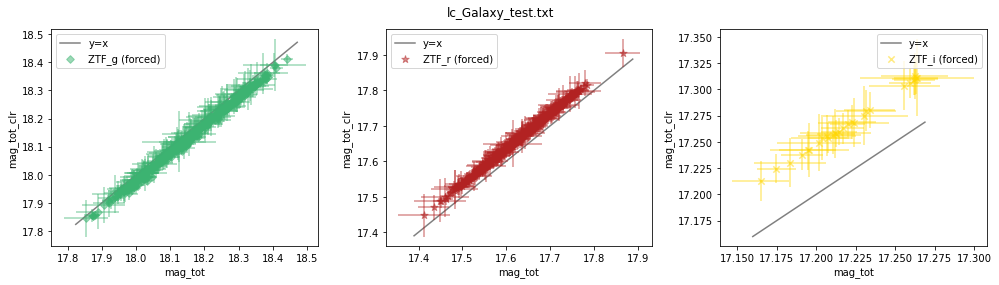

In [27]:
propx = 'mag_tot'
propy = 'mag_tot_clr'
dpropx = 'sigma_mag_tot'
dpropy = 'sigma_mag_tot_clr'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy, dpropx=dpropx, dpropy=dpropy, show_yeqx=True)

Here we can see that this correction slightly shifts the magnitudes.

##### Rescale errors by the square root of the mean of the reduced chi-square in PSF-fit (``forcediffimchis``) per filter and field. 

### This should be the last step in the data processing, to avoid contamination by bad epochs. Use it only after all the data cleaning is done. 

In the ZTF forced photometry manual it is stated that : 'we advise checking the distribution of the PSF-fit reduced χ2 values (forcediffimchisq) 
for a given field and filter, following any quality filtering. This can 
also be examined as a function of flux (forcediffimflux). The average, 'forcediffimchisq', 
should be ≈ 1. If not, we advise multiplying the raw forcediffimfluxunc values by the squared root of  'forcediffimchisq'. '

In order to visualize the distribution of this parameter, we plot histograms of `forcediffimchisq` per `filter` and `field`:

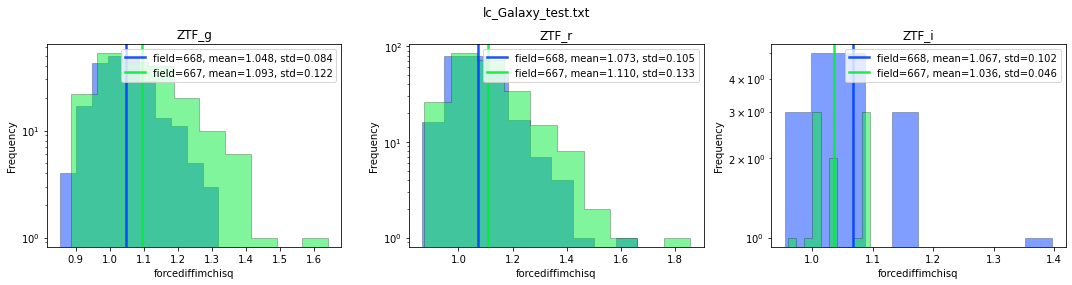

In [28]:
col = 'forcediffimchisq'
col_sec = 'field'
#bins = 10 # use the number of bins at your preference
plot_col_hist_perfilt(df=lc, col=col, col_sec=col_sec, title=namelc, logy=True)#, bins=bins)

This way it can be seen that the errors are not underestimated. 

The rescaling of the error bars can be applied by `filter` and `field` to all the dataset, adding new columns with the values of the rescaled errors (columns ending with 'resc'):

In [29]:
lc, sqrmean_chisq = fp.rescale_errors(df=lc, verbose=True)
lc

Rescale errors by sqrt(mean(forcediffimchisq)) (per filter and field)


c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and w

,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad,nearestrefflux,flux_tot,flux_diff_uJy,sigma_flux_diff_uJy,flux_tot_uJy,fluxunc_tot,SNR_tot,fluxunc_tot_uJy,mag_tot,sigma_mag_tot,mag_diff,sigma_mag_diff,isdiffpos,flux_tot_ap,flux_diff_ap_uJy,sigma_flux_diff_ap_uJy,flux_tot_ap_uJy,fluxunc_tot_ap,SNR_tot_ap,fluxunc_tot_ap_uJy,mag_tot_ap,sigma_mag_tot_ap,mag_diff_ap,sigma_mag_diff_ap,isdiffpos_ap,fid,mag_tot_clr,sigma_mag_tot_clr,mag_tot_ap_clr,sigma_mag_tot_ap_clr,forcediffimfluxunc_resc,sigma_flux_diff_uJy_resc,fluxunc_tot_resc,fluxunc_tot_uJy_resc,SNR_tot_resc,sigma_mag_diff_resc,sigma_mag_tot_resc,sigma_mag_tot_clr_resc
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0,2059.871584,1972.982199,-9.365408,5.077824,212.658706,47.110491,41.879890,5.077824,18.080792,0.025924,21.471183,0.588655,-1,1959.543120,-10.813945,7.732565,211.210169,71.740369,27.314372,7.732565,18.088213,0.039748,21.315040,0.776335,-1,1,18.064879,0.025935,18.072300,0.039755,48.230146,5.198506,48.230146,5.198506,40.907656,0.602645,0.026540,0.026551
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0,1975.695743,1842.289624,-15.214432,4.314193,210.105735,37.828540,48.701050,4.314193,18.093905,0.022293,20.944361,0.307860,-1,1785.901687,-21.645250,6.920721,203.674917,60.683599,29.429726,6.920721,18.127656,0.036891,20.561593,0.347135,-1,1,18.076401,0.022308,18.110152,0.036901,39.554775,4.511063,39.554775,4.511063,46.575657,0.321909,0.023310,0.023325
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0,2092.956232,2113.514941,2.180900,9.209548,224.205015,86.815709,24.344844,9.209548,18.023387,0.044597,23.053410,4.584715,1,2088.915636,-0.428633,14.875516,221.595482,140.227129,14.896658,14.875516,18.036098,0.072882,24.819786,37.678743,-1,1,18.004964,0.044605,18.017675,0.072887,88.879020,9.428427,88.879020,9.428427,23.779683,4.693678,0.045657,0.045665
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0,2083.148098,2038.063342,-4.805181,9.940882,217.218934,93.270627,21.851074,9.940882,18.057756,0.049686,22.195726,2.246079,-1,1925.368110,-16.816357,16.134123,205.207757,151.378909,12.718866,16.134123,18.119516,0.085361,20.835670,1.041654,-1,1,18.043040,0.049691,18.104800,0.085364,95.487350,10.177142,95.

The values that have been used to multiply the errors are the following:

In [30]:
sqrmean_chisq

,filter,field,ndet,sqrmean_chisq
0,ZTF_g,668,223,1.023767
1,ZTF_g,667,197,1.045633
2,ZTF_r,668,257,1.035833
3,ZTF_r,667,244,1.053748
4,ZTF_i,668,17,1.033069
5,ZTF_i,667,11,1.017837


All the steps explained above can be applied in one block as follows:

In [31]:
lc = fp.read_ztf_lc(path=namefil, verbose=True)#, procstatusnumeric=True)
lc = fp.flag_bad_data(df=lc, path=namefil, zp_fil=zp_fil, verbose=True)
lc = fp.clean_data_nanflux_infobits_flagbad(df=lc, verbose=True)
if use1ccd:
    lc = fp.clean_data_ccdid(df=lc, verbose=True)#, show_ccdid=True)
lc = fp.add_props(df=lc, verbose=True)
lc, obj_ps1 = fp.correct_mags_ps1_color(df=lc, path=namefil, r_arcsec=r_arcsec,# use_ps1_table=True,
                                        verbose=True)
lc, sqrmean_chisq = fp.rescale_errors(df=lc, verbose=True)

print('Data ready to use\n')
lc

Read data from file
data/lc_Galaxy_test.txt
Flag bad data
Clean data
Keeping only epochs with valid difference fluxes
Keeping only epochs with infobitsci=0
Keeping only epochs with flag_bad=0
Compute more quantities (total fluxes, difference magnitudes, etc)
Compute apparent magnitudes corrected for Pan-STARRS1 colors
PS1 magnitudes (objID=150041526721551622)
g_ps1=17.9553+-0.0135
r_ps1=17.6356+-0.0067
i_ps1=17.385+-0.03
Rescale errors by sqrt(mean(forcediffimchisq)) (per filter and field)
Data ready to use



c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and w

,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,zpmaginpsciunc,zpmaginpscirms,clrcoeff,clrcoeffunc,ncalmatches,exptime,adpctdif1,adpctdif2,diffmaglim,zpdiff,programid,jd,rfid,forcediffimflux,forcediffimfluxunc,forcediffimsnr,forcediffimchisq,forcediffimfluxap,forcediffimfluxuncap,forcediffimsnrap,aperturecorr,dnearestrefsrc,nearestrefmag,nearestrefmagunc,nearestrefchi,nearestrefsharp,refjdstart,refjdend,procstatus,mjd,secz,CCDquadID,ZPthres,crit1,crit4,flag_bad,nearestrefflux,flux_tot,flux_diff_uJy,sigma_flux_diff_uJy,flux_tot_uJy,fluxunc_tot,SNR_tot,fluxunc_tot_uJy,mag_tot,sigma_mag_tot,mag_diff,sigma_mag_diff,isdiffpos,flux_tot_ap,flux_diff_ap_uJy,sigma_flux_diff_ap_uJy,flux_tot_ap_uJy,fluxunc_tot_ap,SNR_tot_ap,fluxunc_tot_ap_uJy,mag_tot_ap,sigma_mag_tot_ap,mag_diff_ap,sigma_mag_diff_ap,isdiffpos_ap,fid,mag_tot_clr,sigma_mag_tot_clr,mag_tot_ap_clr,sigma_mag_tot_ap_clr,forcediffimfluxunc_resc,sigma_flux_diff_uJy_resc,fluxunc_tot_resc,fluxunc_tot_uJy_resc,SNR_tot_resc,sigma_mag_diff_resc,sigma_mag_tot_resc,sigma_mag_tot_clr_resc
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,668,12,1,ZTF_g,448256574515,0,2.6283,122.7280,7.92373,26.3186,0.000036,0.039543,-0.049776,0.000059,269,30.0,0.054172,0.058370,20.1140,26.3186,1,2.458203e+06,668120145,-86.889384,47.110491,-2.051653,1.055078,-100.328464,71.740369,-1.407913,1.146095,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58202.256574,1.003237,45,25.8771,26.499353,25.676453,0,2059.871584,1972.982199,-9.365408,5.077824,212.658706,47.110491,41.879890,5.077824,18.080792,0.025924,21.471183,0.588655,-1,1959.543120,-10.813945,7.732565,211.210169,71.740369,27.314372,7.732565,18.088213,0.039748,21.315040,0.776335,-1,1,18.064879,0.025935,18.072300,0.039755,48.230146,5.198506,48.230146,5.198506,40.907656,0.602645,0.026540,0.026551
1,667,9,0,ZTF_g,448257043215,0,2.4487,95.5311,7.88483,26.2573,0.000028,0.034766,-0.054751,0.000043,271,30.0,0.056637,0.054081,20.1634,26.2573,1,2.458203e+06,667120132,-133.406119,37.828540,-3.922934,0.938897,-189.794056,60.683599,-3.148665,1.115855,0.237747,18.018,0.032,2.260,0.114,2.458167e+06,2.458438e+06,0,58202.257049,1.003428,32,25.8035,26.499314,25.602814,0,1975.695743,1842.289624,-15.214432,4.314193,210.105735,37.828540,48.701050,4.314193,18.093905,0.022293,20.944361,0.307860,-1,1785.901687,-21.645250,6.920721,203.674917,60.683599,29.429726,6.920721,18.127656,0.036891,20.561593,0.347135,-1,1,18.076401,0.022308,18.110152,0.036901,39.554775,4.511063,39.554775,4.511063,46.575657,0.321909,0.023310,0.023325
2,668,12,1,ZTF_g,451229274515,0,2.4283,121.1520,15.37070,26.3359,0.000042,0.038751,-0.057626,0.000078,210,30.0,0.055486,0.052636,19.3750,26.3359,1,2.458206e+06,668120145,20.558709,86.815709,0.263422,1.073240,-4.040596,140.227129,-0.029009,1.096533,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.229271,1.000676,45,25.8771,26.499865,25.676965,0,2092.956232,2113.514941,2.180900,9.209548,224.205015,86.815709,24.344844,9.209548,18.023387,0.044597,23.053410,4.584715,1,2088.915636,-0.428633,14.875516,221.595482,140.227129,14.896658,14.875516,18.036098,0.072882,24.819786,37.678743,-1,1,18.004964,0.044605,18.017675,0.072887,88.879020,9.428427,88.879020,9.428427,23.779683,4.693678,0.045657,0.045665
3,668,12,1,ZTF_g,451257474515,0,2.3715,123.3370,15.41160,26.3308,0.000038,0.036652,-0.046030,0.000072,211,30.0,0.053723,0.055886,19.3911,26.3308,1,2.458206e+06,668120145,-45.084756,93.270627,-0.537699,0.868910,-157.779987,151.378909,-1.049305,1.106177,0.225821,18.034,0.031,1.965,0.125,2.458167e+06,2.458275e+06,0,58205.257477,1.007979,45,25.8771,26.498404,25.675504,0,2083.148098,2038.063342,-4.805181,9.940882,217.218934,93.270627,21.851074,9.940882,18.057756,0.049686,22.195726,2.246079,-1,1925.368110,-16.816357,16.134123,205.207757,151.378909,12.718866,16.134123,18.119516,0.085361,20.835670,1.041654,-1,1,18.043040,0.049691,18.104800,0.085364,95.487350,10.177142,95.

Now we are ready to examine the data and plot the light curves.

### Exploring the cleaned data

Plot a given column against another to check for unique pairs (useful for identifiers and reference quantities). Let's do this for pairs of properties in the dataframe. In this example we will see that our data has information in two ccdids, fields, qids, and rfids in the three filters.

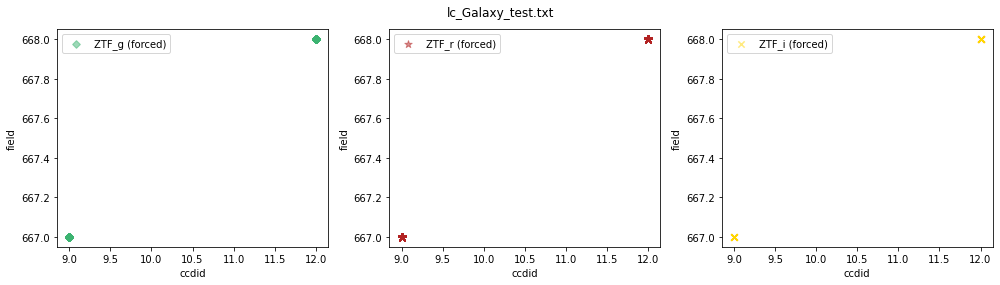

In [32]:
propx = 'ccdid'
propy = 'field'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy)

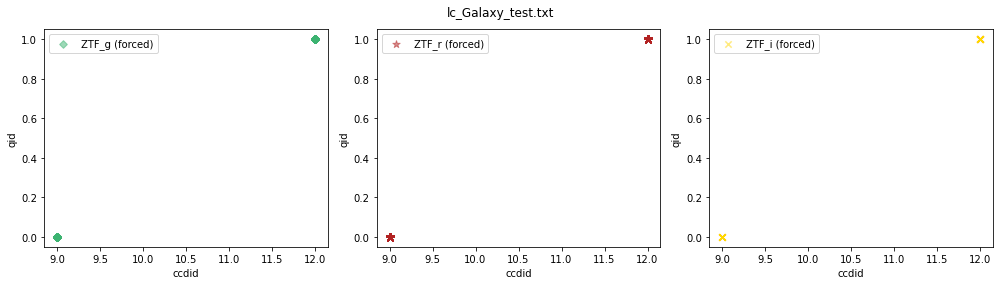

In [33]:
propx = 'ccdid'
propy = 'qid'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy)

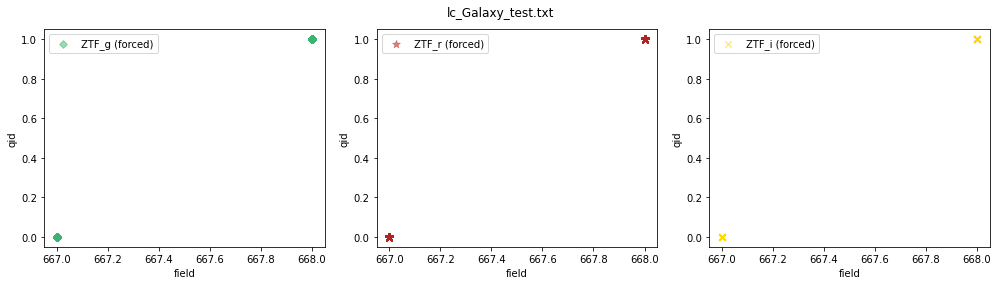

In [34]:
propx = 'field'
propy = 'qid'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy)

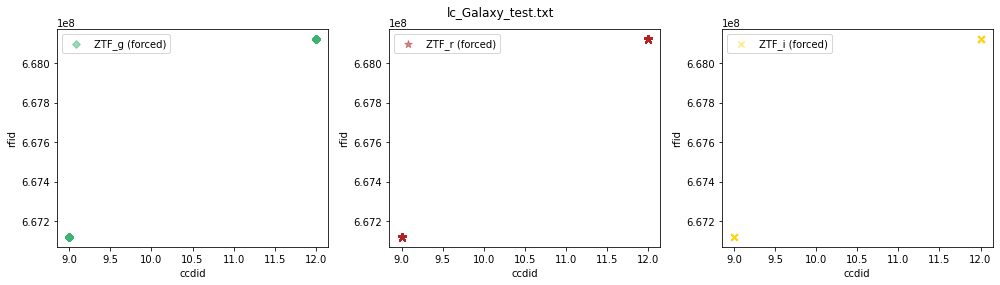

In [35]:
propx = 'ccdid'
propy = 'rfid'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy)

For these properties/columns, let's see their unique values in each of the filters: 

In [36]:
cols = ['field', 'ccdid', 'qid', 'rfid']

for filt in filters:
    mask = lc['filter'] == 'ZTF_'+filt
    print('ZTF_'+filt)
    
    for col in cols:
        print('Unique '+col+' values:', pd.unique(lc[col][mask]))
    
    print('')

ZTF_g
Unique field values: [668 667]
Unique ccdid values: [12  9]
Unique qid values: [1 0]
Unique rfid values: [668120145 667120132]

ZTF_r
Unique field values: [668 667]
Unique ccdid values: [12  9]
Unique qid values: [1 0]
Unique rfid values: [668120245 667120232]

ZTF_i
Unique field values: [668 667]
Unique ccdid values: [12  9]
Unique qid values: [1 0]
Unique rfid values: [668120345 667120332]



### Exit and warning codes

The column ``procstatus`` gives the per-epoch processing status codes. If this is 0, it means that there are no warnings; if non-zero then you can decide whether to use or not the data taking into account the following warnings (for further information see ZTF manual https://zwicky.tf/vgt):

 - 0 => Successful execution
 - 56 => One or more epochs have photometry measurements that may be impacted by bad (including NaN'd) pixels
 - 57 => One or more epochs had no reference image catalog source falling with 5 arcsec
 - 58 => One or more epochs had a reference image PSF-catalog that does not exist in the archive
 - 59 => One or more epochs may have suspect photometric uncertainties due to early creation date of difference image in production
 - 60 => One or more epochs had upsampled diff-image PSF dimensions that were not odd integers
 - 61 => One or more epochs had diff-image cutouts that were off the image or too close to an edge
 - 62 => Requested start JD was before official survey start date [3/17/18] and was reset to 2018-03-17T00:00:00.0 UT
 - 63 => No records (epochs) returned by database query
 - 64 => Catastrophic error (see log output)
 - 65 => Requested end JD is before official survey start date [3/17/18]
 - 255 => Database connection or query execution error (see log output)

Find unique procstatus values and display light curve rows for chosen values

In [37]:
pd.unique(lc['procstatus'])

array(['0'], dtype=object)

So in this case our dataframe contains only rows with procstatus=0.

In case we have values with warnings, we can check which rows include this warning uncommenting the following cell:


In [38]:
#subs = ['63', '64', '255', '56,57']

#fp.print_rows_procstatus(df=lc, title=namelc, subs=subs)

For comparison purposes, we can plot forced difference image PSF-fit flux (obtained after subtracting the reference image to the science image) against forced difference image aperture flux (using the science image) using a fixed 9-pixel diameter aperture. This is done per filter.

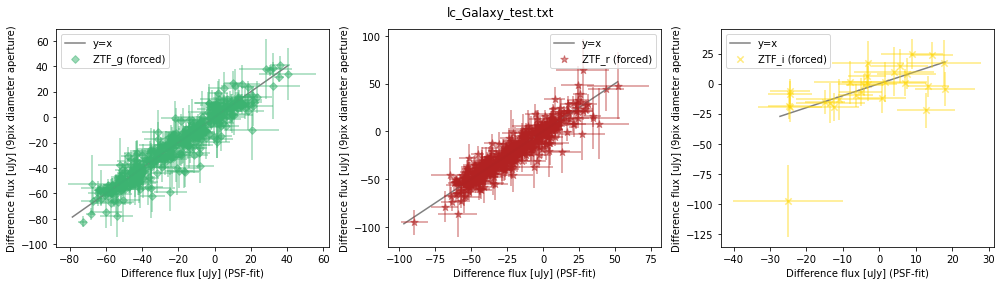

In [39]:
propx = 'flux_diff_uJy'
propy = 'flux_diff_ap_uJy'
dpropx = 'sigma_flux_diff_uJy'
dpropy = 'sigma_flux_diff_ap_uJy'
xlabel = 'Difference flux [uJy] (PSF-fit)'
ylabel = 'Difference flux [uJy] (9pix diameter aperture)'
plot_props_perfilt(df=lc, title=namelc, propx=propx, propy=propy, dpropx=dpropx, dpropy=dpropy,
                   xlabel=xlabel, ylabel=ylabel, show_yeqx=True)

We can see the distribution of different columns, for example let's plot histograms of the photometric zeropoint for the difference image (`zpdiff`) per filter:

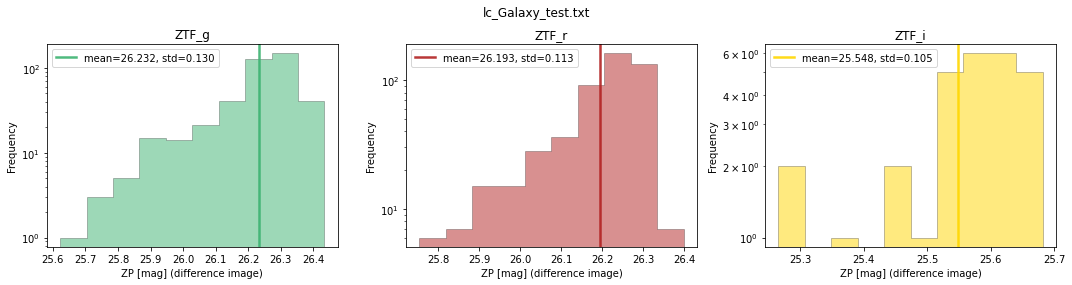

In [40]:
col = 'zpdiff'
colname = 'ZP [mag] (difference image)'
#bins = 50
plot_col_hist_perfilt(df=lc, col=col, colname=colname, title=namelc, logy=True)#, bins=bins)

where the mean and standard deviation of the parameter are given and represented in the plots as solid lines.

### Plotting light curves

Now let's see how to plot the light curves using different fluxes and magnitudes. For this purpose, let's first define the columns that can be used to plot the data. Just keep in mind that depending on the science case that you are developing you will need to use one or other column.


- For epoch: `mjd`
- For filter: `filter` (g, r, i) or `fid` (1, 2, 3)


- Difference flux in uJy (from PSF-fit): `flux_diff_uJy`
- Difference flux uncertainty in uJy (from PSF-fit): `sigma_flux_diff_uJy`
- Difference flux uncertainty in uJy (from PSF-fit), rescaled by the square root of the mean of the reduced chi-square in PSF-fit (`forcediffimchisq`) per filter and field: `sigma_flux_diff_uJy_resc`
- Difference flux in uJy (from 9-pixel diameter aperture): `flux_diff_ap_uJy`
- Difference flux uncertainty in uJy (from 9-pixel diameter aperture): `sigma_flux_diff_ap_uJy`

- Total flux in uJy (from PSF-fit): `flux_tot_uJy` (uses `flux_diff_uJy`)
- Total flux uncertainty in uJy (from PSF-fit): `fluxunc_tot_uJy`
- Total flux uncertainty in uJy (from PSF-fit), rescaled by the square root of `forcediffimchisq` mean per filter and field: `fluxunc_tot_uJy_resc`


- Difference magnitude (from PSF-fit): `mag_diff`, sign of difference given by `isdiffpos`
- Difference magnitude uncertainty (from PSF-fit): `sigma_mag_diff`
- Difference magnitude uncertainty (from PSF-fit), rescaled by the square root of `forcediffimchisq` mean per filter and field: `sigma_mag_diff_resc`


- Apparent magnitude (from PSF-fit): `mag_tot`
- Apparent magnitude (from PSF-fit), corrected for Pan-STARRS1 color: `mag_tot_clr`
- Apparent magnitude uncertainty (from PSF-fit): `sigma_mag_tot`
- Apparent magnitude uncertainty (from PSF-fit), corrected for Pan-STARRS1 color: `sigma_mag_tot_clr`
- Apparent magnitude uncertainty (from PSF-fit), rescaled by the square root of `forcediffimchisq` mean per filter and field: `sigma_mag_tot_resc`
- Apparent magnitude uncertainty (from PSF-fit), corrected for Pan-STARRS1 color, rescaled by the square root of `forcediffimchisq` mean per filter and field: `sigma_mag_tot_clr_resc`



Then we can plot the same light curve using different columns in the y-axis against the epoch in the x-axis:

In [41]:
plot_mag_tot = True
plot_mag_diff = True
plot_flux_diff = True
plot_flux_tot = True

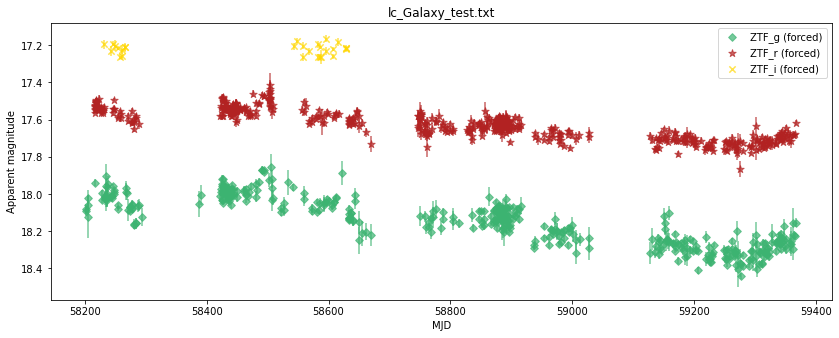

In [42]:
if plot_mag_tot:
    ylabel = 'Apparent magnitude'
    title = namelc
    plot_lc_ztffp(df=lc, title=title, propcol='mag_tot', properrcol='sigma_mag_tot_resc',
                  useflux=False, ylabel=ylabel)
    #title = namelc+', without rescaling errors'
    #plot_lc_ztffp(df=lc, title=title, propcol='mag_tot', properrcol='sigma_mag_tot',
    #              useflux=False, ylabel=ylabel)

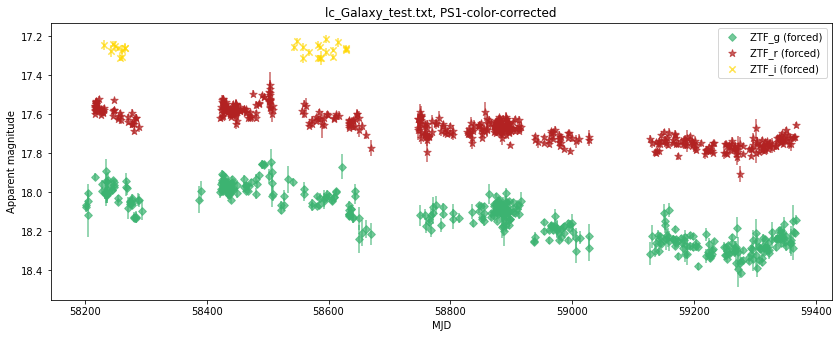

In [43]:
if plot_mag_tot:
    ylabel = 'Apparent magnitude'
    title = namelc+', PS1-color-corrected'
    plot_lc_ztffp(df=lc, title=title, propcol='mag_tot_clr', properrcol='sigma_mag_tot_clr_resc',
                  useflux=False, ylabel=ylabel)
    #title = namelc+', PS1-color-corrected, without rescaling errors'
    #plot_lc_ztffp(df=lc, title=title, propcol='mag_tot_clr', properrcol='sigma_mag_tot_clr',
    #              useflux=False, ylabel=ylabel)

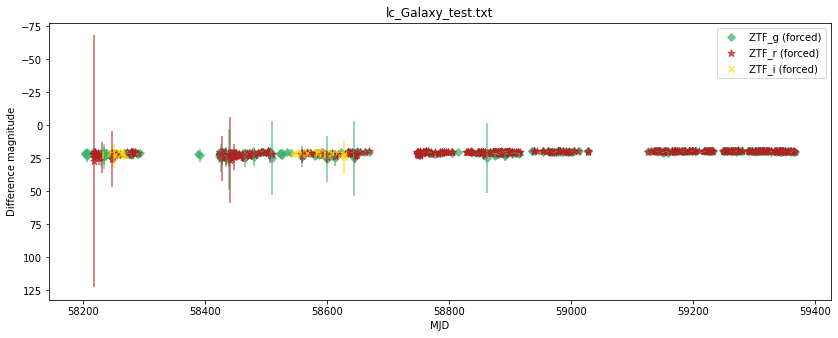

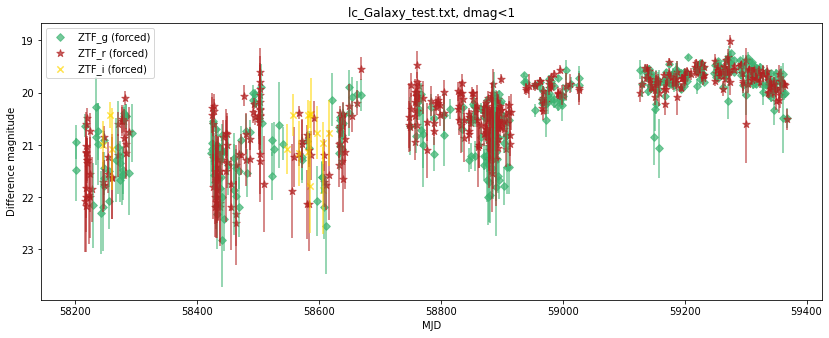

In [44]:
if plot_mag_diff:
    ylabel = 'Difference magnitude'
    title = namelc
    plot_lc_ztffp(df=lc, title=title, propcol='mag_diff', properrcol='sigma_mag_diff_resc',
                  useflux=False, ylabel=ylabel)
    #add a plot including data with errors smaller than 1 mag
    title = namelc+', dmag<1'
    mask = lc['sigma_mag_diff_resc'] < 1. 
    plot_lc_ztffp(df=lc[mask], title=title, propcol='mag_diff', properrcol='sigma_mag_diff_resc',
                  useflux=False, ylabel=ylabel)
    #title = namelc+', without rescaling errors'
    #plot_lc_ztffp(df=lc, title=title, propcol='mag_diff', properrcol='sigma_mag_diff',
    #              useflux=False, ylabel=ylabel)

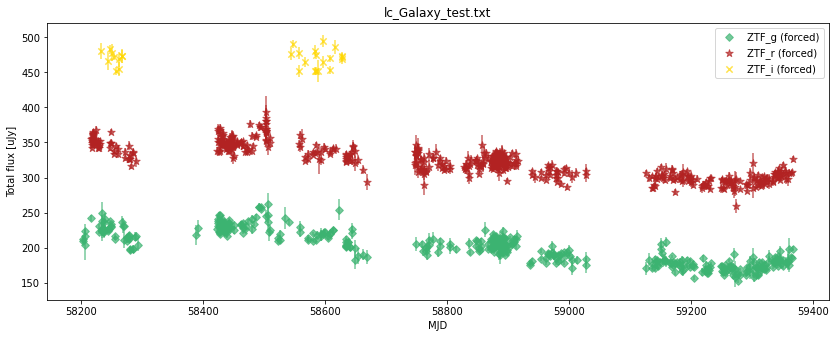

In [45]:
if plot_flux_tot:
    ylabel = 'Total flux [uJy]'
    title = namelc
    plot_lc_ztffp(df=lc, title=title, propcol='flux_tot_uJy', properrcol='fluxunc_tot_uJy_resc',
                  useflux=True, ylabel=ylabel)
    #title = namelc+', without rescaling errors'
    #plot_lc_ztffp(df=lc, title=title, propcol='flux_tot_uJy', properrcol='fluxunc_tot_uJy',
    #              useflux=True, ylabel=ylabel)

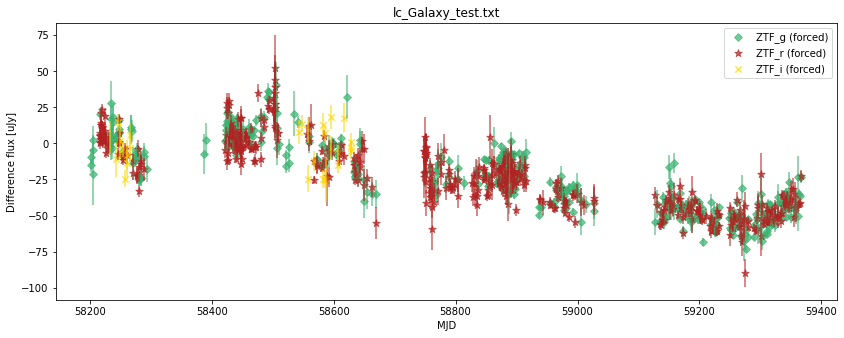

In [46]:
if plot_flux_diff:
    ylabel = 'Difference flux [uJy]'
    title = namelc
    plot_lc_ztffp(df=lc, title=title, propcol='flux_diff_uJy', properrcol='sigma_flux_diff_uJy_resc',
                  useflux=True, ylabel=ylabel)
    #title = namelc+', without rescaling errors'
    #plot_lc_ztffp(df=lc, title=title, propcol='flux_diff_uJy', properrcol='sigma_flux_diff_uJy',
    #              useflux=True, ylabel=ylabel)

## Examples using the sample of light curves in list

Now that we have explored all the options for one light curve, let's use all the sample defined in list (at the beginning of the notebook) to plot their light curves.

First, let's see the number of unique values for each column per light curve and `filter`:

In [47]:
lc_stats_perfilt = pd.DataFrame(columns=['name_lc'])

cols = ['field', 'ccdid', 'qid', 'rfid']

for i, row in lc_list.iterrows():
    namefil = '%s%s' % (row['dir_lc'], row['name_lc'])
    lc = fp.read_ztf_lc(path=namefil)#, procstatusnumeric=True)
    lc = fp.flag_bad_data(df=lc, path=namefil, zp_fil=zp_fil)
    lc = fp.clean_data_nanflux_infobits_flagbad(df=lc)
    if use1ccd:
        lc = fp.clean_data_ccdid(df=lc)#, show_ccdid=True)
    lc = fp.add_props(df=lc)
    lc, obj_ps1 = fp.correct_mags_ps1_color(df=lc, path=namefil, r_arcsec=r_arcsec)#, use_ps1_table=True)
    lc, sqrmean_chisq = fp.rescale_errors(df=lc)
    
    lc_stats_perfilt = lc_stats_perfilt.append({'name_lc': row['name_lc']}, ignore_index=True)
    
    for filt in filters:
        for col in cols:
            mask = lc['filter'] == 'ZTF_'+filt
            uniq = pd.unique(lc[col][mask])
            lc_stats_perfilt.loc[i, 'n'+col+'_'+filt] = len(uniq)

lc_stats_perfilt.set_index('name_lc', inplace=True)

for filt in filters:
    for col in cols:
        lc_stats_perfilt[lc_stats_perfilt['n'+col+'_'+filt].isna()] = 0
        lc_stats_perfilt['n'+col+'_'+filt] = lc_stats_perfilt['n'+col+'_'+filt].astype(int)

c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and w

In [48]:
lc_stats_perfilt

,nfield_g,nccdid_g,nqid_g,nrfid_g,nfield_r,nccdid_r,nqid_r,nrfid_r,nfield_i,nccdid_i,nqid_i,nrfid_i
name_lc,,,,,,,,,,,,
lc_Galaxy_test.txt,2,2,2,2,2,2,2,2,2,2,2,2
ztf_mcg08_Gaia.ascii,2,2,1,2,2,2,1,2,0,0,0,0
lc_111.03675337386362_35.88507155284091_2458194.5_2470000.5.txt,2,2,2,2,2,2,2,2,0,0,0,0
lc_183.96756969615384_18.34910837716346_2458194.5_2470000.5.txt,2,2,2,2,3,3,2,3,2,2,2,2
lc_132.22120816131527_28.403295180077368_2458194.5_2470000.5.txt,2,2,2,2,3,3,2,3,0,0,0,0
lc_195.65377670197367_44.20667155789474_2458194.5_2470000.5.txt,3,3,2,3,3,3,2,3,3,3,2,3


We can also explore the minimum and maximum mjd values per light curve to check the time coverage of the light curves:

In [49]:
lc_stats_minmax = pd.DataFrame(columns=['name_lc'])

for i, row in lc_list.iterrows():
    namefil = '%s%s' % (row['dir_lc'], row['name_lc'])
    lc = fp.read_ztf_lc(path=namefil)#, procstatusnumeric=True)
    lc = fp.flag_bad_data(df=lc, path=namefil, zp_fil=zp_fil)
    lc = fp.clean_data_nanflux_infobits_flagbad(df=lc)
    if use1ccd:
        lc = fp.clean_data_ccdid(df=lc)#, show_ccdid=True)
    lc = fp.add_props(df=lc)
    lc, obj_ps1 = fp.correct_mags_ps1_color(df=lc, path=namefil, r_arcsec=r_arcsec)#, use_ps1_table=True)
    lc, sqrmean_chisq = fp.rescale_errors(df=lc)
    
    lc_stats_minmax = lc_stats_minmax.append({'name_lc': row['name_lc']}, ignore_index=True)
    
    for col in ['mjd']:
        lc_stats_minmax.loc[i, 'min'+col] = lc[col].min()
        lc_stats_minmax.loc[i, 'max'+col] = lc[col].max()
    
lc_stats_minmax.set_index('name_lc', inplace=True)
    
for col in lc_stats_minmax.columns:
    lc_stats_minmax[col] = lc_stats_minmax[col].astype(int)

c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and w

In [50]:
lc_stats_minmax

,minmjd,maxmjd
name_lc,,
lc_Galaxy_test.txt,58202,59367
ztf_mcg08_Gaia.ascii,58204,59325
lc_111.03675337386362_35.88507155284091_2458194.5_2470000.5.txt,58204,59329
lc_183.96756969615384_18.34910837716346_2458194.5_2470000.5.txt,58202,59395
lc_132.22120816131527_28.403295180077368_2458194.5_2470000.5.txt,58202,59356
lc_195.65377670197367_44.20667155789474_2458194.5_2470000.5.txt,58198,59414


It is also interesting to see the values of sqrt(mean(forcediffimchisq)) found for each light curve to see if the errors are underestimated (per `filter` and `field`):

In [51]:
lc_stats_sqrmeanchisq = pd.DataFrame(columns=['name_lc', 'filter', 'field', 'sqrmean_chisq'])

for i, row in lc_list.iterrows():
    namefil = '%s%s' % (row['dir_lc'], row['name_lc'])
    lc = fp.read_ztf_lc(path=namefil)#, procstatusnumeric=True)
    lc = fp.flag_bad_data(df=lc, path=namefil, zp_fil=zp_fil)
    lc = fp.clean_data_nanflux_infobits_flagbad(df=lc)
    if use1ccd:
        lc = fp.clean_data_ccdid(df=lc)#, show_ccdid=True)
    lc = fp.add_props(df=lc)
    lc, obj_ps1 = fp.correct_mags_ps1_color(df=lc, path=namefil, r_arcsec=r_arcsec)#, use_ps1_table=True)
    lc, sqrmean_chisq = fp.rescale_errors(df=lc)
    
    aux = sqrmean_chisq.copy()
    aux['name_lc'] = row['name_lc']
    lc_stats_sqrmeanchisq = lc_stats_sqrmeanchisq.append(aux, ignore_index=True)

lc_stats_sqrmeanchisq.set_index('name_lc', inplace=True)

c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sq = sq.append({'filter': 'ZTF_'+filt, 'field': field,
c:\Users\Seba\Downloads\alerce_ztffp_tools\alerce_ztffp_tools\lib\alerce_ztffp_tools.py:455: FutureWarning: The frame.append method is deprecated and w

In [52]:
lc_stats_sqrmeanchisq

,filter,field,sqrmean_chisq,ndet
name_lc,,,,
lc_Galaxy_test.txt,ZTF_g,668,1.023767,223
lc_Galaxy_test.txt,ZTF_g,667,1.045633,197
lc_Galaxy_test.txt,ZTF_r,668,1.035833,257
lc_Galaxy_test.txt,ZTF_r,667,1.053748,244
lc_Galaxy_test.txt,ZTF_i,668,1.033069,17
lc_Galaxy_test.txt,ZTF_i,667,1.017837,11
ztf_mcg08_Gaia.ascii,ZTF_g,745,3.680219,127
ztf_mcg08_Gaia.ascii,ZTF_g,1744,2.723156,26
ztf_mcg08_Gaia.ascii,ZTF_r,745,6.651377,135


In most cases the value of `sqrmean_chisq` is close to one, meaning that the errors are well estimated. In the case of 'ztf_mcg08_Gaia.ascii', however, the values are large in both filters and fields, meaning that the errors are underestimated.

We advise the usage of IRSA tools to visualize the ZTF data:

https://irsa.ipac.caltech.edu/Missions/ztf.html

And in particular to check the ZTF images to see how our sources look:


https://irsa.ipac.caltech.edu/applications/ztf/?__action=layout.showDropDown&

For example, the source in the file ztf_mcg08_Gaia.ascii is the nearby galaxy MCG+08-11-11. One of its ZTF images in the g-filter looks like this:

![mcg08](figures/mcg08.png)

so it can be seen that this is an extended source. This can explain why the errors are underestimated for this source.

We can also check the number of unique values for some columns in given filters per light curve and see their distribution in the following histograms:

c:\Users\Seba\anaconda3\lib\site-packages\pandas\core\indexes\api.py:166: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = Index(array_sorted, name=index.name)


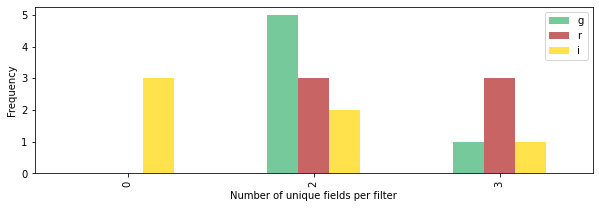

In [53]:
col = 'nfield'
colname = 'Number of unique fields per filter'
plot_col_hist_perfilt_stats(df_stats=lc_stats_perfilt, col=col, colname=colname)

c:\Users\Seba\anaconda3\lib\site-packages\pandas\core\indexes\api.py:166: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = Index(array_sorted, name=index.name)


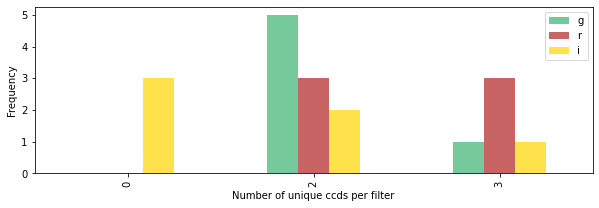

In [54]:
col = 'nccdid'
colname = 'Number of unique ccds per filter'
plot_col_hist_perfilt_stats(df_stats=lc_stats_perfilt, col=col, colname=colname)

c:\Users\Seba\anaconda3\lib\site-packages\pandas\core\indexes\api.py:166: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = Index(array_sorted, name=index.name)


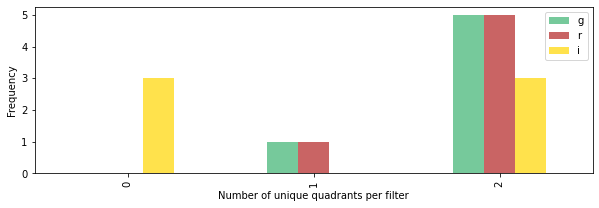

In [55]:
col = 'nqid'
colname = 'Number of unique quadrants per filter'
plot_col_hist_perfilt_stats(df_stats=lc_stats_perfilt, col=col, colname=colname)

c:\Users\Seba\anaconda3\lib\site-packages\pandas\core\indexes\api.py:166: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = Index(array_sorted, name=index.name)


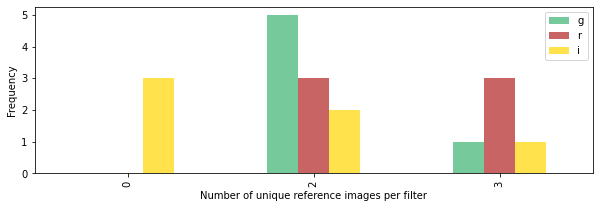

In [56]:
col = 'nrfid'
colname = 'Number of unique reference images per filter'
plot_col_hist_perfilt_stats(df_stats=lc_stats_perfilt, col=col, colname=colname)

In general, there should be coincident `ccdid`, `qid`, `field` and `rfid`, but there could be cases where this is not true. Check if there are light curves having no coincidences in the number of unique values for some columns (for a given filter):

In [57]:
for filt in filters:
    df = lc_stats_perfilt[lc_stats_perfilt['nccdid_'+filt] != lc_stats_perfilt['nrfid_'+filt]]
    print(str(len(df))+' light curves having nccdid_'+filt+' != nrfid_'+filt)
    if len(df) != 0:
        display(df)

0 light curves having nccdid_g != nrfid_g
0 light curves having nccdid_r != nrfid_r
0 light curves having nccdid_i != nrfid_i


Congrats! You have done it through the notebook!